# Install and load dependencies

In [6]:
%pip install pydeseq2
%pip install scanpy
%pip install sanbomics
%pip install bioinfokit
%pip install gseapy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [7]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from functools import reduce
from sanbomics.plots import volcano
from bioinfokit import analys,visuz
from gseapy.plot import gseaplot

import pandas as pd
import seaborn as sns
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import sys
import gseapy as gp

# Data cleaning

In [8]:
primary = pd.read_csv('../data/raw/ogprimary_undiff_metadata.tsv', delimiter='\t')
primary.set_index(primary.columns[0], inplace=True)
primary.sort_index(inplace=True)
primary = primary.iloc[:5]

In [9]:
diff = pd.read_csv('../data/raw/primary_and_goodDiffs_metadata.tsv', delimiter='\t')
diff.set_index(diff.columns[0], inplace=True)
diff.sort_index(inplace=True)
diff = diff.iloc[:-5]

In [10]:
merged = pd.concat([diff, primary])
merged = merged.dropna(axis=1)

# Run DeSeq2

In [11]:
merged *= 100
merged = merged.astype(int)

In [12]:
labels = ['Differentiated'] * 16 + ['Primary'] * 5

metadata = pd.DataFrame(zip(merged.index, labels),
                        columns = ['Sample', 'Condition'])
metadata = metadata.set_index('Sample')

In [13]:
dds = DeseqDataSet(counts=merged,
            metadata=metadata,
            design_factors="Condition",
            ref_level = ["Condition", "Primary"])

In [14]:
dds.deseq2()

Fitting size factors...
... done in 0.01 seconds.

/Users/shahjess/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/shahjess/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/shahjess/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/shahjess/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/shahjess/anaconda3/lib/python3.11/site-pac

In [15]:
stat_res = DeseqStats(dds, contrast = ('Condition','Primary','Differentiated'))

stat_res.summary()
res = stat_res.results_df

Running Wald tests...


Log2 fold change & Wald test p-value: Condition Primary vs Differentiated
             baseMean  log2FoldChange     lfcSE      stat        pvalue  \
A1BG     10312.340885       -2.464994  1.206713 -2.042735  4.107868e-02   
A1CF      1099.749973      -12.636913  2.002460 -6.310693  2.777882e-10   
A2M      17769.772481       -5.368196  0.815645 -6.581533  4.656236e-11   
A2ML1      146.315574       -9.727080  2.251966 -4.319373  1.564731e-05   
A3GALT2      1.873825        3.471071  3.460116  1.003166  3.157807e-01   
...               ...             ...       ...       ...           ...   
ZXDB      2084.329175       -1.653158  0.525992 -3.142935  1.672629e-03   
ZXDC      2614.986088       -1.444965  0.269193 -5.367763  7.971909e-08   
ZYG11B    4128.949808        0.225123  0.552723  0.407298  6.837891e-01   
ZYX      10020.989373        0.496028  0.714288  0.694437  4.874083e-01   
ZZEF1     2047.131289       -0.798189  0.358196 -2.228359  2.585660e-02   

                 padj  
A

... done in 0.50 seconds.



# Heat Map

In [16]:
sys.setrecursionlimit(10000)  # Set a higher recursion limit (adjust the value as needed)

In [17]:
dds.layers['log1p'] = np.log1p(dds.layers['normed_counts'])
dds_res = dds[:, res.index]

pattern_repetitions = {'ESC-CM': 5, 'iPSC-CM': 11, 'Primary-CM': 5}
col_labels = [f'{pattern} {i}' for pattern, repetitions in pattern_repetitions.items() for i in range(1, repetitions + 1)]

grapher_res = pd.DataFrame(dds_res.layers['log1p'].T,
                       index=dds_res.var_names, columns=col_labels)

# Heatmap of cardiac genes

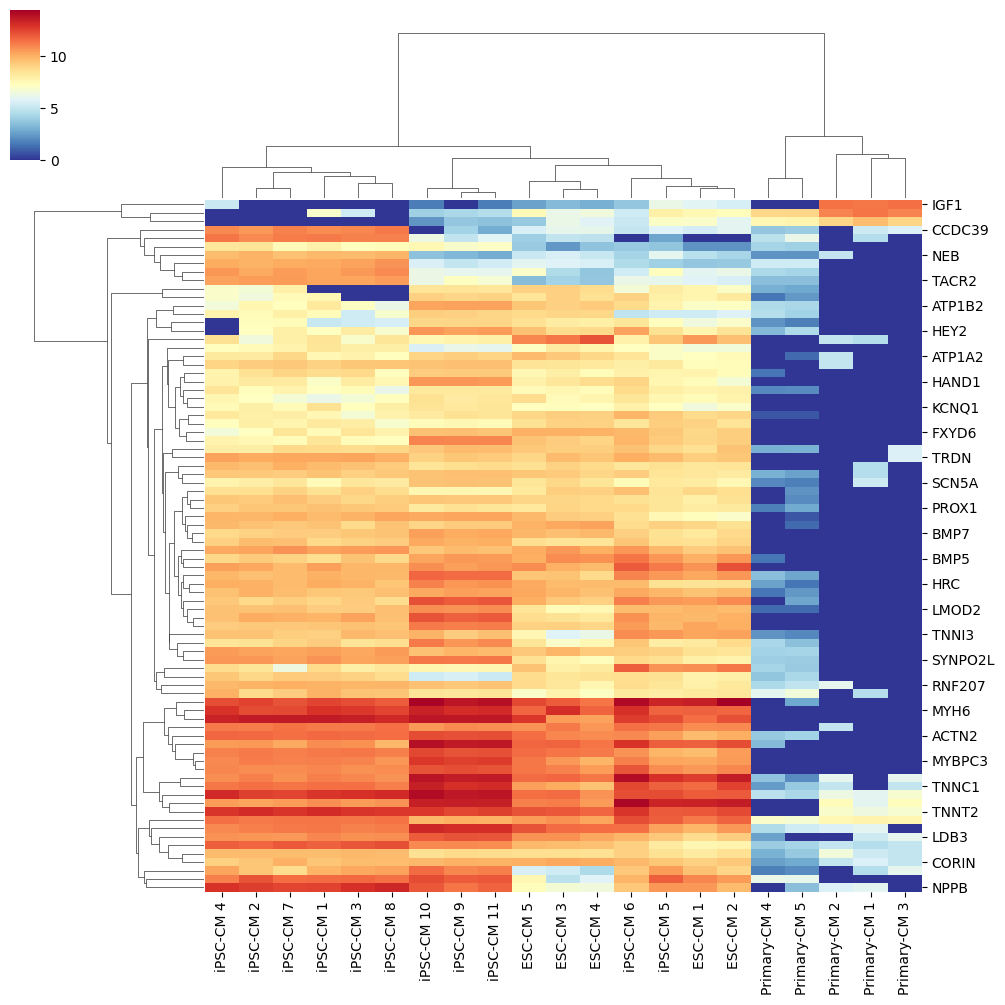

In [19]:
cardiac_genes = pd.read_csv('../data/raw/cardiac_genes.csv', delimiter='\t')
common_genes = cardiac_genes['Gene'][cardiac_genes['Gene'].isin(grapher_res.index)]
subset_grapher_res = grapher_res.loc[common_genes]

sns.clustermap(subset_grapher_res, cmap='RdYlBu_r',cbar_pos=(0, .85, .03, .15))
plt.savefig('../figures/Fig S3a Original Primary vs Diff Cardiac Heatmap')